In [1]:
import matplotlib as mpl
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy as sp
import datetime
import talib
import matplotlib.pylab as plt
import os
#from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import sklearn.metrics
import graphviz
from numpy import *

 # Feature Importance
from sklearn import datasets
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

<h2>The below code is about a Long/Short strategy on Nifty at monthly intervals. The strategy signals are generated using supervised Machine Learning algorithms; also backtesting results of the strategy is presented :</h2>

1) The input dataset has Nifty Monthly OHLC data along with some technical analysis parameters like Pivot Points, RSI, ADX, Exponential moving averages, MACD, etc. <br>
2) Strategy will output Long/Short signals and 'No trade' signal at end of last trading day of every month using combination of technical parameters as features for the two supervised machine learning algorithms used for prediction purpose. <br>
3) The ML model is trained on dataset from inception of Nifty till end of 2012. Backtesting period is from start of 2013 till Sep 2020. <br>
4) The two supervised ML models used are Random Forest & Support Vector Machine classification models. <br>
5) There are two seperate runs for each of the two models used - one for giving long/short signals on target variable based on Close to Close prices while other one for giving long/short signals on target variable based on Close above or below pivot points. <br>
6) Finally, the four outputs from two runs of the two ML models are combined to give one final signal using certain rules.<br>
7) Strategy backtest results are at last analysed in terms of accuracy, sharpe ratio, volatility, model biasness, CAGR returns and shape of the equity curve. <br>
8) Hyperparamters of Random Forest Model include max features (number of features to consider when looking for the best split) is 50; the Random Forest model output of 70 runs is then averaged to get one final outputfrom that model and each run has minimum of 10 trees abd max of 80 trees;the depth of trees is kept till 7 nodes.<br>
9) Hyperparameters for SVM model include Kernel set to Radial Basis Function (RBF) for prediction of non-linear relationships; C is kept at 10 and gamma is set to 0.01 so as manage the tradeoff between Smooth models (lower gamma values) which can be made more complex by increasing the importance of classifying each point correctly (larger C values) hence capturing the diagonal of good performing models. Also the predictors (features) are transformed using scalar transform which is suitable for SVM model.


In [2]:
dtree=pd.read_csv("G:\Documents\Documents\Finance work\Nifty monthly full.csv",index_col=1)
dtree.index = pd.to_datetime(dtree.index)
dtree['TREG']=(dtree['Close'].shift(-1)>dtree['Pivot'].shift(-1)).astype(int)
dtree['TREGS']=(dtree['Close']<dtree['Close'].shift(-1)).astype(int)
#dtree['TREG']=(dtree['Low'].shift(-1)<dtree['S1'].shift(-1)).astype(int)
dtree['MACD_b']=(dtree['MACD']>0).astype(int)
dtree['MACD_blag']=(dtree['MACD'].shift(1)>0).astype(int)

#Demark rules
Hcond=[dtree['Close'].shift(1)<dtree['Open'].shift(1),dtree['Close'].shift(1)>dtree['Open'].shift(1)]
Hcalc=[(dtree['High'].shift(1)+2*dtree['Low'].shift(1)+dtree['Close'].shift(1))/2 - dtree['Low'].shift(1),
       (2*dtree['High'].shift(1)+dtree['Low'].shift(1)+dtree['Close'].shift(1))/2 - dtree['Low'].shift(1)]
Lcond=[dtree['Close'].shift(1)<dtree['Open'].shift(1),dtree['Close'].shift(1)>dtree['Open'].shift(1)]
Lcalc=[(dtree['High'].shift(1)+2*dtree['Low'].shift(1)+dtree['Close'].shift(1))/2 - dtree['High'].shift(1),
       (2*dtree['High'].shift(1)+dtree['Low'].shift(1)+dtree['Close'].shift(1))/2 - dtree['High'].shift(1)]
dtree['FH']=np.select(Hcond,Hcalc)
dtree['FL']=np.select(Lcond,Lcalc)
#Fib points
dtree['RF1']=dtree['Pivot']+(dtree['High'].shift(1)-dtree['Low'].shift(1))*0.382
dtree['RF2']=dtree['Pivot']+(dtree['High'].shift(1)-dtree['Low'].shift(1))*0.618
dtree['RF3']=dtree['Pivot']+(dtree['High'].shift(1)-dtree['Low'].shift(1))*1
dtree['SF1']=dtree['Pivot']-(dtree['High'].shift(1)-dtree['Low'].shift(1))*0.382
dtree['SF2']=dtree['Pivot']-(dtree['High'].shift(1)-dtree['Low'].shift(1))*0.618
dtree['SF3']=dtree['Pivot']-(dtree['High'].shift(1)-dtree['Low'].shift(1))*1
#Camarilla points
dtree['RC1']=dtree['Close'].shift(1)+(dtree['High'].shift(1)-dtree['Low'].shift(1))*1.0833
dtree['RC2']=dtree['Close'].shift(1)+(dtree['High'].shift(1)-dtree['Low'].shift(1))*1.1666
dtree['RC3']=dtree['Close'].shift(1)+(dtree['High'].shift(1)-dtree['Low'].shift(1))*1.2500
dtree['RC4']=dtree['Close'].shift(1)+(dtree['High'].shift(1)-dtree['Low'].shift(1))*1.5000
dtree['SC1']=dtree['Close'].shift(1)-(dtree['High'].shift(1)-dtree['Low'].shift(1))*1.0833
dtree['SC2']=dtree['Close'].shift(1)-(dtree['High'].shift(1)-dtree['Low'].shift(1))*1.1666
dtree['SC3']=dtree['Close'].shift(1)-(dtree['High'].shift(1)-dtree['Low'].shift(1))*1.2500
dtree['SC4']=dtree['Close'].shift(1)-(dtree['High'].shift(1)-dtree['Low'].shift(1))*1.5000
#Woodie points
dtree['PW']=(2*dtree['Close'].shift(1)+dtree['High'].shift(1)+dtree['Low'].shift(1))/4
dtree['RW1']=2*dtree['PW']-dtree['Low'].shift(1)
dtree['RW2']=dtree['PW']+(dtree['High'].shift(1)-dtree['Low'].shift(1))*1
dtree['SW1']=2*dtree['PW']-dtree['High'].shift(1)
dtree['SW2']=dtree['PW']-dtree['High'].shift(1)+dtree['Low'].shift(1)

dtree['ADXs_b']=(dtree['ADXs']>1).astype(int)
dtree['ADXs_blag']=(dtree['ADXs'].shift(1)>1).astype(int)
dtree['C/P']=(dtree['Close']>dtree['Pivot']).astype(int)
dtree['C/Plag']=(dtree['Close'].shift(1)>dtree['Pivot'].shift(1)).astype(int)
dtree['C/R1']=(dtree['Close']>dtree['R1']).astype(int)
dtree['C/R1lag']=(dtree['Close'].shift(1)>dtree['R1'].shift(1)).astype(int)
dtree['C/R2']=(dtree['Close']>dtree['R2']).astype(int)
dtree['C/R2lag']=(dtree['Close'].shift(1)>dtree['R2'].shift(1)).astype(int)
dtree['C/S1']=(dtree['Close']<dtree['S1']).astype(int)
dtree['C/S1lag']=(dtree['Close'].shift(1)<dtree['S1'].shift(1)).astype(int)
dtree['C/S2']=(dtree['Close']<dtree['S2']).astype(int)
dtree['C/S2lag']=(dtree['Close'].shift(1)<dtree['S2'].shift(1)).astype(int)
dtree['EMA_b']=(dtree['Close']>dtree['EMA1']).astype(int)
dtree['EMA_blag']=(dtree['Close'].shift(1)>dtree['EMA1'].shift(1)).astype(int)
dtree['trend']=(dtree['Close']>dtree['Close'].shift(1)).astype(int)
dtree['trendlag']=(dtree['Close'].shift(1)>dtree['Close'].shift(2)).astype(int)
dtree['CR2']=((dtree['High']>dtree['R2']) & (dtree['High'].shift(1)>dtree['R2'].shift(1))).astype(int)
dtree['CR2lag']=dtree['CR2'].shift(1)
dtree['CR1']=((dtree['High']>dtree['R1']) & (dtree['High'].shift(1)>dtree['R1'].shift(1))).astype(int)
dtree['CR1lag']=dtree['CR1'].shift(1)
dtree['CS1']=((dtree['Low']<dtree['S1']) & (dtree['Low'].shift(1)<dtree['S1'].shift(1))).astype(int)
dtree['CS1lag']=dtree['CS1'].shift(1)
dtree['CS2']=((dtree['Low']<dtree['S2']) & (dtree['Low'].shift(1)<dtree['S2'].shift(1))).astype(int)
dtree['CS2lag']=dtree['CS2'].shift(1)
dtree['R1hit']=(dtree['High']>dtree['R1']).astype(int)
dtree['R1hitlag']=dtree['R1hit'].shift(1)
dtree['R2hit']=(dtree['High']>dtree['R2']).astype(int)
dtree['R2hitlag']=dtree['R2hit'].shift(1)
dtree['S1hit']=(dtree['Low']<dtree['S1']).astype(int)
dtree['S1hitlag']=dtree['S1hit'].shift(1)
dtree['S2hit']=(dtree['Low']<dtree['S2']).astype(int)
dtree['S2hitlag']=dtree['S2hit'].shift(1)

dtree['PL']=(dtree['Pivot']<dtree['Low']).astype(int)
dtree['PLlag']=dtree['PL'].shift(1)
dtree['PH']=(dtree['Pivot']>dtree['High']).astype(int)
dtree['PHlag']=dtree['PH'].shift(1)
dtree['R1S1']=((dtree['R1hit']==1) & (dtree['S1hit']==1)).astype(int)
dtree['R1S1lag']=dtree['R1S1'].shift(1)
dtree['R2S1']=((dtree['R2hit']==1) & (dtree['S1hit']==1)).astype(int)
dtree['R2S1lag']=dtree['R2S1'].shift(1)
dtree['CR1S1']=((dtree['R1S1']==1) & (dtree['R1S1'].shift(1)==1)).astype(int)
dtree['CR1S1lag']=dtree['CR1S1'].shift(1)
dtree['compositelag']=dtree['composite'].shift(1)
dtree['ADXlag']=dtree['ADX'].shift(1)

dtree['C/PW']=(dtree['Close']>dtree['PW']).astype(int)
dtree['C/RF1']=(dtree['Close']>dtree['RF1']).astype(int)
dtree['C/RF2']=(dtree['Close']>dtree['RF2']).astype(int)
dtree['C/SF1']=(dtree['Close']<dtree['SF1']).astype(int)
dtree['C/SF2']=(dtree['Close']<dtree['SF2']).astype(int)
dtree['C/RF3']=(dtree['Close']>dtree['RF3']).astype(int)
dtree['C/SF3']=(dtree['Close']<dtree['SF3']).astype(int)

dtree['RF1hit']=(dtree['High']>dtree['RF1']).astype(int)
dtree['RF1hitlag']=dtree['RF1hit'].shift(1)
dtree['RF2hit']=(dtree['High']>dtree['RF2']).astype(int)
dtree['RF2hitlag']=dtree['RF2hit'].shift(1)
dtree['SF1hit']=(dtree['Low']<dtree['SF1']).astype(int)
dtree['SF1hitlag']=dtree['SF1hit'].shift(1)
dtree['SF2hit']=(dtree['Low']<dtree['SF2']).astype(int)
dtree['SF2hitlag']=dtree['SF2hit'].shift(1)
dtree['CRF2']=((dtree['High']>dtree['RF2']) & (dtree['High'].shift(1)>dtree['RF2'].shift(1))).astype(int)
dtree['CRF2lag']=dtree['CRF2'].shift(1)
dtree['CRF1']=((dtree['High']>dtree['RF1']) & (dtree['High'].shift(1)>dtree['RF1'].shift(1))).astype(int)
dtree['CRF1lag']=dtree['CRF1'].shift(1)
dtree['CSF1']=((dtree['Low']<dtree['SF1']) & (dtree['Low'].shift(1)<dtree['SF1'].shift(1))).astype(int)
dtree['CSF1lag']=dtree['CSF1'].shift(1)
dtree['CSF2']=((dtree['Low']<dtree['SF2']) & (dtree['Low'].shift(1)<dtree['SF2'].shift(1))).astype(int)
dtree['CSF2lag']=dtree['CSF2'].shift(1)
dtree['RF1SF1']=((dtree['RF1hit']==1) & (dtree['SF1hit']==1)).astype(int)
dtree['RF1SF1lag']=dtree['RF1SF1'].shift(1)
dtree['RF2SF1']=((dtree['RF2hit']==1) & (dtree['SF1hit']==1)).astype(int)
dtree['RF2SF1lag']=dtree['RF2SF1'].shift(1)
dtree['CRF1SF1']=((dtree['RF1SF1']==1) & (dtree['RF1SF1'].shift(1)==1)).astype(int)
dtree['CRF1SF1lag']=dtree['CRF1SF1'].shift(1)

dtree['C/RC1']=(dtree['Close']>dtree['RC1']).astype(int)
dtree['C/RC2']=(dtree['Close']>dtree['RC2']).astype(int)
dtree['C/SC1']=(dtree['Close']<dtree['SC1']).astype(int)
dtree['C/SC2']=(dtree['Close']<dtree['SC2']).astype(int)
dtree['C/RC3']=(dtree['Close']>dtree['RC3']).astype(int)
dtree['C/SC3']=(dtree['Close']<dtree['SC3']).astype(int)
dtree['C/RC4']=(dtree['Close']>dtree['RC4']).astype(int)
dtree['C/SC4']=(dtree['Close']<dtree['SC4']).astype(int)

dtree['RC1hit']=(dtree['High']>dtree['RC1']).astype(int)
dtree['RC1hitlag']=dtree['RC1hit'].shift(1)
dtree['RC2hit']=(dtree['High']>dtree['RC2']).astype(int)
dtree['RC2hitlag']=dtree['RC2hit'].shift(1)
dtree['SC1hit']=(dtree['Low']<dtree['SC1']).astype(int)
dtree['SC1hitlag']=dtree['SC1hit'].shift(1)
dtree['SC2hit']=(dtree['Low']<dtree['SC2']).astype(int)
dtree['SC2hitlag']=dtree['SC2hit'].shift(1)
dtree['RC3hit']=(dtree['High']>dtree['RC3']).astype(int)
dtree['RC3hitlag']=dtree['RC3hit'].shift(1)
dtree['SC3hit']=(dtree['Low']<dtree['SC3']).astype(int)
dtree['SC3hitlag']=dtree['SC3hit'].shift(1)

dtree['CRC3']=((dtree['High']>dtree['RC3']) & (dtree['High'].shift(1)>dtree['RC3'].shift(1))).astype(int)
dtree['CRC3lag']=dtree['CRC3'].shift(1)
dtree['CRC2']=((dtree['High']>dtree['RC2']) & (dtree['High'].shift(1)>dtree['RC2'].shift(1))).astype(int)
dtree['CRC2lag']=dtree['CRC2'].shift(1)
dtree['CRC1']=((dtree['High']>dtree['RC1']) & (dtree['High'].shift(1)>dtree['RC1'].shift(1))).astype(int)
dtree['CRC1lag']=dtree['CRC1'].shift(1)
dtree['CSC1']=((dtree['Low']<dtree['SC1']) & (dtree['Low'].shift(1)<dtree['SC1'].shift(1))).astype(int)
dtree['CSC1lag']=dtree['CSC1'].shift(1)
dtree['CSC2']=((dtree['Low']<dtree['SC2']) & (dtree['Low'].shift(1)<dtree['SC2'].shift(1))).astype(int)
dtree['CSC2lag']=dtree['CSC2'].shift(1)
dtree['CSC3']=((dtree['Low']<dtree['SC3']) & (dtree['Low'].shift(1)<dtree['SC3'].shift(1))).astype(int)
dtree['CSC3lag']=dtree['CSC3'].shift(1)
dtree['RC1SC1']=((dtree['RC1hit']==1) & (dtree['SC1hit']==1)).astype(int)
dtree['RC1SC1lag']=dtree['RC1SC1'].shift(1)
dtree['RC2SC1']=((dtree['RC2hit']==1) & (dtree['SC1hit']==1)).astype(int)
dtree['RC2SC1lag']=dtree['RC2SC1'].shift(1)
dtree['CRC1SC1']=((dtree['RC1SC1']==1) & (dtree['RC1SC1'].shift(1)==1)).astype(int)
dtree['CRC1SC1lag']=dtree['CRC1SC1'].shift(1)
dtree['RC3SC2']=((dtree['RC3hit']==1) & (dtree['SC2hit']==1)).astype(int)
dtree['RC3SC2lag']=dtree['RC3SC2'].shift(1)
dtree['RC2SC2']=((dtree['RC2hit']==1) & (dtree['SC2hit']==1)).astype(int)
dtree['RC2SC2lag']=dtree['RC2SC2'].shift(1)
dtree['CRC2SC2']=((dtree['RC2SC2']==1) & (dtree['RC2SC2'].shift(1)==1)).astype(int)
dtree['CRC2SC2lag']=dtree['CRC2SC2'].shift(1)

dtree['C/RW1']=(dtree['Close']>dtree['RW1']).astype(int)
dtree['C/RW2']=(dtree['Close']>dtree['RW2']).astype(int)
dtree['C/SW1']=(dtree['Close']<dtree['SW1']).astype(int)
dtree['C/SW2']=(dtree['Close']<dtree['SW2']).astype(int)

dtree['RW1hit']=(dtree['High']>dtree['RW1']).astype(int)
dtree['RW1hitlag']=dtree['RW1hit'].shift(1)
dtree['RW2hit']=(dtree['High']>dtree['RW2']).astype(int)
dtree['RW2hitlag']=dtree['RW2hit'].shift(1)
dtree['SW1hit']=(dtree['Low']<dtree['SW1']).astype(int)
dtree['SW1hitlag']=dtree['SW1hit'].shift(1)
dtree['SW2hit']=(dtree['Low']<dtree['SW2']).astype(int)
dtree['SW2hitlag']=dtree['SW2hit'].shift(1)

dtree['CRW2']=((dtree['High']>dtree['RW2']) & (dtree['High'].shift(1)>dtree['RW2'].shift(1))).astype(int)
dtree['CRW2lag']=dtree['CRW2'].shift(1)
dtree['CRW1']=((dtree['High']>dtree['RW1']) & (dtree['High'].shift(1)>dtree['RW1'].shift(1))).astype(int)
dtree['CRW1lag']=dtree['CRW1'].shift(1)
dtree['CSW1']=((dtree['Low']<dtree['SW1']) & (dtree['Low'].shift(1)<dtree['SW1'].shift(1))).astype(int)
dtree['CSW1lag']=dtree['CSW1'].shift(1)
dtree['CSW2']=((dtree['Low']<dtree['SW2']) & (dtree['Low'].shift(1)<dtree['SW2'].shift(1))).astype(int)
dtree['CSW2lag']=dtree['CSW2'].shift(1)
dtree['RW1SW1']=((dtree['RW1hit']==1) & (dtree['SW1hit']==1)).astype(int)
dtree['RW1SW1lag']=dtree['RW1SW1'].shift(1)
dtree['RW2SW1']=((dtree['RW2hit']==1) & (dtree['SW1hit']==1)).astype(int)
dtree['RW2SW1lag']=dtree['RW2SW1'].shift(1)
dtree['CRW1SW1']=((dtree['RW1SW1']==1) & (dtree['RW1SW1'].shift(1)==1)).astype(int)
dtree['CRW1SW1lag']=dtree['CRW1SW1'].shift(1)

dtree['compcross']=((dtree['composite'].shift(1)<0) & (dtree['composite']>0)).astype(int)
dtree['compcross10']=((dtree['composite'].shift(1)<10) & (dtree['composite']>10)).astype(int)
dtree['RSIfast']=talib.EMA(dtree['RSI'],timeperiod=9)
dtree['RSIslow']=talib.EMA(dtree['RSI'],timeperiod=45)
dtree['RSIslowhit']=(dtree['RSI']>dtree['RSIslow']).astype(int)
dtree['RSIfasthit']=(dtree['RSI']>dtree['RSIfast']).astype(int)
dtree['RSIfastslow']=(dtree['RSIfast']>dtree['RSIslow']).astype(int)
dtree['RSIfastslowcross']=((dtree['RSIfastslow'].shift(1)==0) & (dtree['RSIfastslow']==1)).astype(int)
dtree['RSIfastcross']=((dtree['RSIfasthit'].shift(1)==0) & (dtree['RSIfasthit']==1)).astype(int)
dtree['RSIslowcross']=((dtree['RSIslowhit'].shift(1)==0) & (dtree['RSIslowhit']==1)).astype(int)
ADXcond=[dtree['ADXs_b']==1,dtree['ADXs_b']==0]
ADXmcal=[dtree['ADX']*1,dtree['ADX']*-1]
dtree['ADXm']=np.select(ADXcond,ADXmcal,default=dtree['ADX']*1)
dtree['S1d']=dtree['Low']/dtree['S1']-1
#dtree[(dtree['SF1hit']==0) & (dtree['S1hit']==1)].count()
dtree['R1d']=dtree['R1']/(dtree['Close'].shift(1))
#dtree[ (dtree['Close']>=dtree['Pivot'])]
#dtree[(dtree['RF1hit']==1)]['R1d']['2010':'2018'].median()
#dtree[(dtree['FH']*1.01>dtree['High']) & (dtree['Magic']==1)]
dtree['S2d']=dtree['Close'].shift(1)/dtree['S2']
#dtree[(dtree['S2d']<1.065) & (dtree['C/S2']==0)]
dtree[(dtree['C/R1']==1) & (dtree['TREG']==0) & (dtree['RSI']>70) & (dtree['RSI']<75) & (dtree['ADXm']>35)].count()
dtree[(dtree['C/S2lag']==1) & (dtree['C/S1']==1) & (dtree['S2hit']==1)]['1994':'2018']
dtree['ADXm']['2018']

Date/Time
2018-01-31    30.24
2018-02-28    31.88
2018-03-28    32.25
2018-04-30    32.94
2018-05-31    33.80
2018-06-29    34.61
2018-07-31    35.95
2018-08-31    37.59
2018-09-28    37.85
2018-10-31    35.98
2018-11-30    34.24
2018-12-31    32.74
Name: ADXm, dtype: float64

In [3]:
#The Random Forest model is made to 

In [4]:
predictors=dtree[['MACD_b','MACD_blag','RC1hit','RC1hitlag','RC2hit','RC2hitlag','SC1hit','SC1hitlag','SC2hit','SC2hitlag','RC3hit','RC3hitlag',
                  'SC3hit','SC3hitlag','CRC1SC1lag','RC3SC2','RC3SC2lag','CRC3','CRC3lag','CRC2','CRC2lag','CRC1','CRC1lag',
                  'CSC1','CSC1lag','CSC2','CSC2lag','CSC3','CSC3lag','RC1SC1','RC1SC1lag','RC2SC1','RC2SC1lag','CRC1SC1',
                  'RF1hit','RF1hitlag','RF2hit','RF2hitlag','SF1hit','SF1hitlag','SF2hit','SF2hitlag','CRF2','CRF2lag','CRF1',
                  'CRF1lag','CSF1','CSF1lag','CSF2','CSF2lag','RF1SF1','RF1SF1lag','RF2SF1','RF2SF1lag','CRF1SF1','CRF1SF1lag',
                  'CRW2','CRW2lag','CSW1','CSW1lag','CRW1','CRW1lag','CSW2','CSW2lag','RW1SW1','RW1SW1lag','RW2SW1','RW2SW1lag',
                  'CRW1SW1','CRW1SW1lag','RC2SC2','RC2SC2lag','CRC2SC2','CRC2SC2lag','RW1hit','RW1hitlag','RW2hitlag','SW1hitlag',
                  'SW2hit','SW2hitlag','SW1hit','RW2hit','R1hit','R2hit','S1hit','S2hit','C/P','EMA_b','C/R1','C/R2','C/S1','C/S2',
                  'CR1','CR2','CS1','CS2','trend','trendlag','PL','PH','R1S1','CR1S1','C/Plag','C/R1lag','C/R2lag','C/S1lag','C/S2lag',
                  'CR1lag','CR2lag','CS1lag','CS2lag','PLlag','PHlag','CR1S1lag', 'C/PW','C/RF1','C/RF2','C/RF3','C/SF1','C/SF2','C/SF3',
                  'C/RC1','C/RC2','C/RC3','C/RC4','C/SC1','C/SC2','C/SC3','C/SC4','R1hitlag','R2hitlag','S1hitlag','S2hitlag','RSI','ADXs_b',
                  'composite','ADXm','compcross','compcross10','RSIslowhit','RSIfasthit','RSIfastslow','RSIfastslowcross','RSIfastcross','RSIslowcross']]

targets=dtree.TREG

a=59

dt=pd.DataFrame(columns=['RF','SVM','b'])

for b in range(226, len(predictors)-2):

    x_train=pred_train=predictors.iloc[a:b+1]
    x_test=pred_test=predictors.iloc[b+1:b+2]
    y_train=targ_train=targets.iloc[a:b+1]
    y_test=targ_test=targets.iloc[b+1:b+2]
    
    trees=range(70)
    accuracy=np.zeros(70)

    for idx in range(len(trees)):
        random.seed(456+idx)
        rclassifier=RandomForestClassifier(n_estimators=idx + 10,max_depth=7,max_features=50)
        rclassifier=rclassifier.fit(pred_train,targ_train)
        rpredictions=rclassifier.predict(pred_test)
        accuracy[idx]=sklearn.metrics.accuracy_score(targ_test, rpredictions)
    dt.loc[b+2,['RF']]=accuracy.mean()
    
    
    scaler = MinMaxScaler()
    scalers = StandardScaler()
    scalern = Normalizer()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    
    svmr = SVC(kernel = 'rbf', C=10,gamma=0.01,probability=True).fit(x_train_scaled, y_train)

    svmrpredictions=svmr.predict(x_test_scaled)

    svmrpredictionstrain=svmr.predict(x_train_scaled)
    dt.loc[b+2,['SVM']]=svmr.score(x_test_scaled, y_test)
    dt.loc[b+2,['b']]=b+2

F:\Anaconda\Newfolder\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [5]:
len(predictors)

323

In [6]:
predictors=dtree[['MACD_b','MACD_blag','RC1hit','RC1hitlag','RC2hit','RC2hitlag','SC1hit','SC1hitlag','SC2hit','SC2hitlag','RC3hit','RC3hitlag',
                  'SC3hit','SC3hitlag','CRC1SC1lag','RC3SC2','RC3SC2lag','CRC3','CRC3lag','CRC2','CRC2lag','CRC1','CRC1lag',
                  'CSC1','CSC1lag','CSC2','CSC2lag','CSC3','CSC3lag','RC1SC1','RC1SC1lag','RC2SC1','RC2SC1lag','CRC1SC1',
                  'RF1hit','RF1hitlag','RF2hit','RF2hitlag','SF1hit','SF1hitlag','SF2hit','SF2hitlag','CRF2','CRF2lag','CRF1',
                  'CRF1lag','CSF1','CSF1lag','CSF2','CSF2lag','RF1SF1','RF1SF1lag','RF2SF1','RF2SF1lag','CRF1SF1','CRF1SF1lag',
                  'CRW2','CRW2lag','CSW1','CSW1lag','CRW1','CRW1lag','CSW2','CSW2lag','RW1SW1','RW1SW1lag','RW2SW1','RW2SW1lag',
                  'CRW1SW1','CRW1SW1lag','RC2SC2','RC2SC2lag','CRC2SC2','CRC2SC2lag','RW1hit','RW1hitlag','RW2hitlag','SW1hitlag',
                  'SW2hit','SW2hitlag','SW1hit','RW2hit','R1hit','R2hit','S1hit','S2hit','C/P','EMA_b','C/R1','C/R2','C/S1','C/S2',
                  'CR1','CR2','CS1','CS2','trend','trendlag','PL','PH','R1S1','CR1S1','C/Plag','C/R1lag','C/R2lag','C/S1lag','C/S2lag',
                  'CR1lag','CR2lag','CS1lag','CS2lag','PLlag','PHlag','CR1S1lag', 'C/PW','C/RF1','C/RF2','C/RF3','C/SF1','C/SF2','C/SF3',
                  'C/RC1','C/RC2','C/RC3','C/RC4','C/SC1','C/SC2','C/SC3','C/SC4','R1hitlag','R2hitlag','S1hitlag','S2hitlag','RSI','ADXs_b',
                  'composite','ADXm','compcross','compcross10','RSIslowhit','RSIfasthit','RSIfastslow','RSIfastslowcross','RSIfastcross','RSIslowcross']]

targets=dtree.TREGS
#pred_train, pred_test, targ_train, targ_test  =   train_test_split(predictors, targets, test_size=.4)
a=59

dS=pd.DataFrame(columns=['RFS','SVMS','bs'])

for b in range(226, len(predictors)-2):

    x_train=pred_train=predictors.iloc[a:b+1]
    x_test=pred_test=predictors.iloc[b+1:b+2]
    y_train=targ_train=targets.iloc[a:b+1]
    y_test=targ_test=targets.iloc[b+1:b+2]

    classifier=DecisionTreeClassifier(max_depth=7)
    classifier=classifier.fit(pred_train,targ_train)

    predictions=classifier.predict(pred_test)

   
    trees=range(70)
    accuracy=np.zeros(70)

    for idx in range(len(trees)):
        random.seed(789+idx)
        rclassifier=RandomForestClassifier(n_estimators=idx + 10,max_depth=7,max_features=50)
        rclassifier=rclassifier.fit(pred_train,targ_train)
        rpredictions=rclassifier.predict(pred_test)
        accuracy[idx]=sklearn.metrics.accuracy_score(targ_test, rpredictions)
    dS.loc[b+2,['RFS']]=accuracy.mean()
    
    
    scaler = MinMaxScaler()
    scalers = StandardScaler()
    scalern = Normalizer()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    
    svmr = SVC(kernel = 'rbf', C=10,gamma=0.01,probability=True).fit(x_train_scaled, y_train)

    svmrpredictions=svmr.predict(x_test_scaled)

    svmrpredictionstrain=svmr.predict(x_train_scaled)
    dS.loc[b+2,['SVMS']]=svmr.score(x_test_scaled, y_test)
    dS.loc[b+2,['bs']]=b+2

In [7]:
dataset=dtree.copy()

In [8]:
dataset=dataset.reset_index()

In [9]:
dataset.index

RangeIndex(start=0, stop=323, step=1)

In [10]:
f=pd.merge(dataset,dt,how="left",left_index=True,right_index=True)

In [11]:
final=pd.merge(f,dS,how="left",left_index=True,right_index=True)

In [12]:
final

,Date/Time,Ticker,Open,High,Low,Close,Pivot,R2,S1,R1,...,ADXm,S1d,R1d,S2d,RF,SVM,b,RFS,SVMS,bs
0,1994-01-31,Nifty 90's,1083.74,1272.87,1082.80,1246.59,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1994-02-28,Nifty 90's,1229.93,1349.49,1195.39,1349.49,1200.75,1390.82,1128.64,1318.71,...,NaN,0.059142,1.057854,1.233417,NaN,NaN,NaN,NaN,NaN,NaN
2,1994-03-31,Nifty 90's,1304.40,1304.40,1153.84,1177.11,1298.12,1452.22,1246.76,1400.86,...,NaN,-0.074529,1.038066,1.179604,NaN,NaN,NaN,NaN,NaN,NaN
3,1994-04-29,Nifty 90's,1182.33,1229.70,1147.98,1150.66,1211.78,1362.34,1119.17,1269.73,...,NaN,0.025742,1.078684,1.109205,NaN,NaN,NaN,NaN,NaN,NaN
4,1994-05-31,Nifty 90's,1148.76,1210.82,1121.63,1187.19,1176.11,1257.83,1122.53,1204.25,...,NaN,-0.000802,1.046573,1.051417,NaN,NaN,NaN,NaN,NaN,NaN
5,1994-06-30,Nifty 90's,1186.06,1318.56,1186.06,1249.44,1173.21,1262.40,1135.61,1224.80,...,NaN,0.044425,1.031680,1.095174,NaN,NaN,NaN,NaN,NaN,NaN
6,1994-07-29,Nifty 90's,1262.06,1278.54,1241.22,1278.54,1251.35,1383.85,1184.15,1316.65,...,NaN,0.048195,1.053792,1.116718,NaN,NaN,NaN,NaN,NaN,NaN
7,1994-08-31,Nifty 90's,1308.08,1373.29,1303.35,1373.29,1266.10,1303.42,1253.66,1290.98,...,NaN,0.039636,1.009730,1.040495,NaN,NaN,NaN,NaN,NaN,NaN
8,1994-09-30,Nifty 90's,1366.32,1384.94,1290.53,1290.53,1349.98,1419.92,1326.66,1396.60,...,NaN,-0.027234,1.016974,1.072849,NaN,NaN,NaN,NaN,NaN,NaN
9,1994-10-31,Nifty 90's,1304.83,1326.63,1267.21,1267.21,1322.00,1416.41,1259.06,1353.47,...,NaN,0.006473,1.048771,1.051271,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
final['RFSsignal']=np.where(final['RFS']>0.5, 1, 0)
final['RFsignal']=np.where(final['RF']>0.5,1,0)
final['returns']=final['Close'].pct_change()

In [14]:
final['trade']=np.where((final['RFsignal']==1) & (final['SVM']==1) & (final['RFSsignal']==1) & (final['SVMS']==1) & (final['returns']>0),"Long",
np.where((final['RFsignal']==1) & (final['SVM']==1) & (final['RFSsignal']==1) & (final['SVMS']==1) & (final['returns']<0),"Short",
np.where((final['RFsignal']==1) & (final['SVM']==1) & (final['RFSsignal']==0) & (final['SVMS']==1) & (final['returns']>0),"Long",
np.where((final['RFsignal']==1) & (final['SVM']==1) & (final['RFSsignal']==0) & (final['SVMS']==1) & (final['returns']<0),"Short",
#np.where((final['RFsignal']==1) & (final['SVM']==1) & (final['RFS']>=0.401) & (final['RFS']<=0.599) & (final['SVMS']==1) & (final['returns']>0),"Long",
#np.where((final['RFsignal']==1) & (final['SVM']==1) & (final['RFS']>=0.401) & (final['RFS']<=0.599) & (final['SVMS']==1) & (final['returns']<0),"Short", 
np.where((final['RFsignal']==1) & (final['SVM']==1) & (final['RFSsignal']==0) & (final['SVMS']==0) & (final['C/P']==1),"Long",
np.where((final['RFsignal']==1) & (final['SVM']==1) & (final['RFSsignal']==0) & (final['SVMS']==0) & (final['C/P']==0),"Short",
np.where((final['RFsignal']==0) & (final['SVM']==0) & (final['RFSsignal']==1) & (final['SVMS']==1) & (final['C/P']==0),"Long",
np.where((final['RFsignal']==0) & (final['SVM']==0) & (final['RFSsignal']==1) & (final['SVMS']==1) & (final['C/P']==1),"Short",
np.where((final['RFsignal']==1) & (final['SVM']==0) & (final['RFSsignal']==1) & (final['SVMS']==1) & (final['returns']>0),"Long",
np.where((final['RFsignal']==1) & (final['SVM']==0) & (final['RFSsignal']==1) & (final['SVMS']==1) & (final['returns']<0),"Short",
np.where((final['RFsignal']==0) & (final['SVM']==1) & (final['RFSsignal']==1) & (final['SVMS']==1) & (final['returns']>0),"Long",
np.where((final['RFsignal']==0) & (final['SVM']==1) & (final['RFSsignal']==1) & (final['SVMS']==1) & (final['returns']<0),"Short",
np.where((final['RFsignal']==1) & (final['SVM']==0) & (final['RFSsignal']==1) & (final['SVMS']==0),"NT",
np.where((final['RFsignal']==0) & (final['SVM']==1) & (final['RFSsignal']==1) & (final['SVMS']==0) ,"NT",
np.where((final['RFsignal']==1) & (final['SVM']==0) & (final['RFSsignal']==0) & (final['SVMS']==1),"NT",
np.where((final['RFsignal']==0) & (final['SVM']==1) & (final['RFSsignal']==0) & (final['SVMS']==1) ,"NT",
np.where((final['RFsignal']==1) & (final['SVM']==1) & (final['RFSsignal']==1) & (final['SVMS']==0) ,"NT",
np.where((final['RFsignal']==0) & (final['SVM']==0) & (final['RFSsignal']==0) & (final['SVMS']==1) ,"NT",
np.where((final['RFsignal']==0) & (final['SVM']==0) & (final['RFSsignal']==0) & (final['SVMS']==0) & (final['returns']>0),"Short",
np.where((final['RFsignal']==0) & (final['SVM']==0) & (final['RFSsignal']==0) & (final['SVMS']==0) & (final['returns']<0),"Long",
np.where((final['RFsignal']==0) & (final['SVM']==0) & (final['RFSsignal']==1) & (final['SVMS']==0) & (final['returns']>0),"Short",
np.where((final['RFsignal']==0) & (final['SVM']==0) & (final['RFSsignal']==1) & (final['SVMS']==0) & (final['returns']<0),"Long",
np.where((final['RFsignal']==1) & (final['SVM']==0) & (final['RFSsignal']==0) & (final['SVMS']==0) & (final['returns']>0),"Short",
np.where((final['RFsignal']==1) & (final['SVM']==0) & (final['RFSsignal']==0) & (final['SVMS']==0) & (final['returns']<0),"Long",         
np.where((final['RFsignal']==0) & (final['SVM']==1) & (final['RFSsignal']==0) & (final['SVMS']==0) & (final['returns']<0),"Long", 
np.where((final['RFsignal']==0) & (final['SVM']==1) & (final['RFSsignal']==0) & (final['SVMS']==0) & (final['returns']>0),"Short",0))))))))))))))))))))))))))      

In [15]:
final['pnl']=np.where(final['trade']=="Long",final['returns'],
             np.where(final['trade']=="Short",-final['returns'],
             np.where(final['trade']=="NT",0,0)))

final[final['trade']==0]


,Date/Time,Ticker,Open,High,Low,Close,Pivot,R2,S1,R1,...,SVM,b,RFS,SVMS,bs,RFSsignal,RFsignal,returns,trade,pnl


In [16]:
final['equity']=(1+final['pnl']).cumprod()

In [17]:

final['nifty_returns']=(1+final['returns']).cumprod()

F:\Anaconda\Newfolder\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


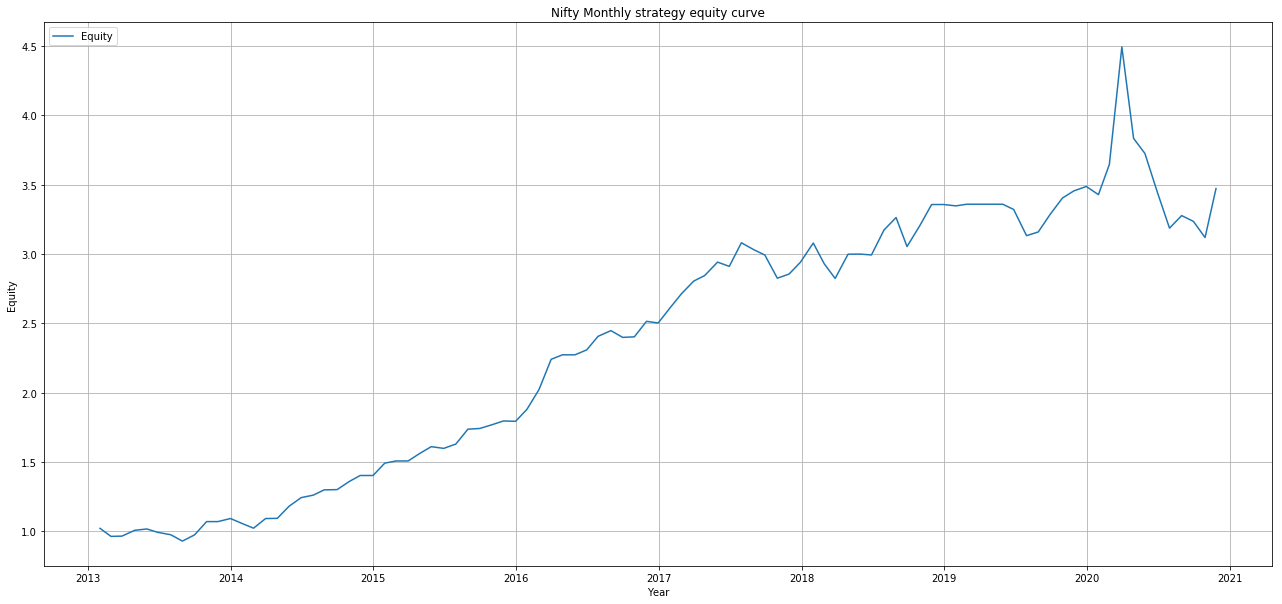

In [18]:
n=228
plt.rcParams["figure.figsize"] = (22,10)
plt.plot(final['Date/Time'].iloc[n:],final['equity'].iloc[n:])
plt.legend(['Equity'], loc='upper left')
plt.xlabel("Year")
plt.ylabel("Equity")
plt.title("Nifty Monthly strategy equity curve",loc='center')
plt.grid(True)
plt.show()

In [19]:
#final.to_csv("G:\Documents\Documents\Finance work\MLof.csv")

In [20]:

CAGR=(final['equity'].iloc[(len(final)-1)]/final['equity'].iloc[n])**(1/((len(final)-n-1)/12.0))-1
nifty_CAGR=(final['nifty_returns'].iloc[(len(final)-1)]/final['nifty_returns'].iloc[n])**(1/((len(final)-n-1)/12.0))-1
print('CAGR: {:.2%}' .format(CAGR))
print('Nifty CAGR: {:.2%}' .format(nifty_CAGR))
volatility=final['equity'].iloc[n:].pct_change().std()
Sharpe= ((CAGR-0.06)/volatility)
print('Volatility: {:.2%}' .format(volatility))
print('Sharpe ratio: {:.4f}' .format(Sharpe))
print ('Long trades count: {:.0f}' .format(final[final['trade']=="Long"]['trade'].count()))
print ('Short trades count: {:.0f}' .format(final[final['trade']=="Short"]['trade'].count()))
print ('No trades count: {:.0f}' .format(final[final['trade']=="NT"]['trade'].count()))
print ('Long trades avg returns: {:.2%}' .format(final[final['trade']=="Long"]["pnl"].mean()))
print ('Short trades avg returns: {:.2%}' .format(final[final['trade']=="Short"]["pnl"].mean()))
#print ('No trades: {:.2%}' .format(final[final['trade']=="NT"]["returns"].mean()))
print ('Accuracy for total long/short trades: {:.2%}' .format(final[final['pnl']>0]['trade'].count()/(86.0)))

CAGR: 16.90%
Nifty CAGR: 10.26%
Volatility: 4.74%
Sharpe ratio: 2.2993
Long trades count: 64
Short trades count: 23
No trades count: 8
Long trades avg returns: 1.74%
Short trades avg returns: 1.06%
Accuracy for total long/short trades: 68.60%
